In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import more_itertools

from numpy import array
from keras.models import Sequential
from keras.layers import ConvLSTM2D, LSTM, Dense, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
from sklearn.metrics import mean_squared_error

# Preparação dos dados

Dividir uma sequência univariada em amostras

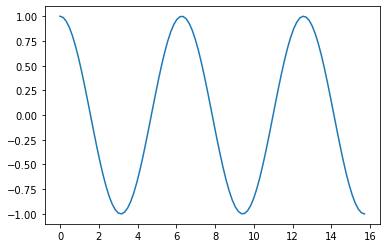

In [15]:
X = np.linspace(0, 5*np.pi, 100, endpoint=True)
C = np.cos(X)

# transform numpy array to list
C = C.tolist()

plt.plot(X, C)
plt.show()

In [18]:
print(C)

[1.0, 0.9874388886763943, 0.9500711177409454, 0.8888354486549235, 0.8052702575310586, 0.7014748877063213, 0.5800569095711982, 0.44406661260577424, 0.2969203753282749, 0.14231483827328512, -0.015865963834807807, -0.1736481776669303, -0.32706796331742166, -0.4722710747726826, -0.6056096871376665, -0.7237340381050702, -0.8236765814298327, -0.9029265382866211, -0.9594929736144974, -0.9919548128307953, -0.9994965423831852, -0.9819286972627067, -0.9396926207859084, -0.873849377069785, -0.7860530947427874, -0.6785094115571322, -0.5539200638661105, -0.4154150130018864, -0.2664738136900355, -0.11083819990101122, 0.04758191582374238, 0.20480666806519018, 0.35688622159187167, 0.5000000000000001, 0.6305526670845221, 0.7452644496757546, 0.8412535328311812, 0.9161084574320694, 0.9679487013963562, 0.9954719225730846, 0.9979866764718844, 0.975429786885407, 0.9283679330160726, 0.8579834132349773, 0.7660444431189781, 0.654860733945285, 0.5272254676105028, 0.3863451256931288, 0.2357589355094271, 0.079249

Podemos dividir a sequência em vários padrões de entrada / saída chamados amostras, onde quatro etapas de tempo são usadas como entrada e uma etapa de tempo é usada como saída para a previsão de uma etapa que está sendo aprendida.

In [21]:
# Função para dividir uma sequência univariada em amostras para o método de janelas
# X - amostras de entrada; y - variável que será predita

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [24]:
# Escolha do numero de passos no tempo
n_steps = 4

X, y = split_sequence(C, n_steps)

for i in range(len(X)):
	print(X[i], y[i])

[1.         0.98743889 0.95007112 0.88883545] 0.8052702575310586
[0.98743889 0.95007112 0.88883545 0.80527026] 0.7014748877063213
[0.95007112 0.88883545 0.80527026 0.70147489] 0.5800569095711982
[0.88883545 0.80527026 0.70147489 0.58005691] 0.44406661260577424
[0.80527026 0.70147489 0.58005691 0.44406661] 0.2969203753282749
[0.70147489 0.58005691 0.44406661 0.29692038] 0.14231483827328512
[0.58005691 0.44406661 0.29692038 0.14231484] -0.015865963834807807
[ 0.44406661  0.29692038  0.14231484 -0.01586596] -0.1736481776669303
[ 0.29692038  0.14231484 -0.01586596 -0.17364818] -0.32706796331742166
[ 0.14231484 -0.01586596 -0.17364818 -0.32706796] -0.4722710747726826
[-0.01586596 -0.17364818 -0.32706796 -0.47227107] -0.6056096871376665
[-0.17364818 -0.32706796 -0.47227107 -0.60560969] -0.7237340381050702
[-0.32706796 -0.47227107 -0.60560969 -0.72373404] -0.8236765814298327
[-0.47227107 -0.60560969 -0.72373404 -0.82367658] -0.9029265382866211
[-0.60560969 -0.72373404 -0.82367658 -0.90292654]

# Reshape

As amostras de input têm que ser dividas em subamostras de 2 timesteps cada. Cada subsequência é interpretada pela CNN e alimentada como input para a lstm processar.

In [28]:
n_features = 1 # série temporal univariada (uma variável de predição)

n_seq = 2 
n_steps = 2 #num. de timesteps por subamostra

In [32]:
X.shape

(96, 4)

In [36]:
# mudar o formato de [amostras, timesteps] para [amostras, timesteps, linhas, colunas, features]
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

In [40]:
X.shape

(96, 2, 1, 2, 1)

In [44]:
X[0:4]

array([[[[[1.        ],
          [0.98743889]]],


        [[[0.95007112],
          [0.88883545]]]],



       [[[[0.98743889],
          [0.95007112]]],


        [[[0.88883545],
          [0.80527026]]]],



       [[[[0.95007112],
          [0.88883545]]],


        [[[0.80527026],
          [0.70147489]]]],



       [[[[0.88883545],
          [0.80527026]]],


        [[[0.70147489],
          [0.58005691]]]]])

# Divisão da série temporal em treino e teste

In [48]:
# As 60 primeiras linhas como treino
X_train = X[0:60]

In [53]:
# O restante das linhas como teste
X_test = X[60:]

Analogamente para a variável preditora

In [59]:
y_train = y[0:60]

In [66]:
y_test = y[60:]

# Modelos LSTM para séries temporais univariadas

Nesse problema de previsão de cosseno, tratamos de um caso de série temporal univariada. Sendo assim, podemos aplicar os seguintes modelos LSTM:

* Vanilla LSTM
* Stacked LSTM
* Bidirectional LSTM
* CNN LSTM
* ConvLSTM

## CNN LSTM

Redes neurais CNN são compostas principalmente de **camada de convolução** e **camada de agrupamento**. Cada camada de convolução têm vários kérneis de convolução. Depois da operação de convolução, os recursos dos dados são extraídos, mas as dimensões são muito grandes. Pra resolver esse problema e reduzir o custo de treinamento da rede, a camada de agrupamento é adicionada.

O modelo pode ser usado em um formato híbrido com um backend LSTM onde a CNN interpreta as subsequências de input que são alimentadas em conjunto como uma sequência para o modelo LSTM processar. Esse modelo híbrido pe chamado de CNN-LSTM.

## Definindo o modelo LSTM CNN

In [82]:
from keras.layers import ConvLSTM2D

In [90]:
# Definindo o modelo
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [98]:
# fit model
model.fit(X_train, y_train, epochs=1000, verbose=2)

Epoch 1/1000
2/2 - 3s - loss: 0.5154
Epoch 2/1000
2/2 - 0s - loss: 0.4978
Epoch 3/1000
2/2 - 0s - loss: 0.4820
Epoch 4/1000
2/2 - 0s - loss: 0.4660
Epoch 5/1000
2/2 - 0s - loss: 0.4496
Epoch 6/1000
2/2 - 0s - loss: 0.4350
Epoch 7/1000
2/2 - 0s - loss: 0.4201
Epoch 8/1000
2/2 - 0s - loss: 0.4058
Epoch 9/1000
2/2 - 0s - loss: 0.3916
Epoch 10/1000
2/2 - 0s - loss: 0.3776
Epoch 11/1000
2/2 - 0s - loss: 0.3642
Epoch 12/1000
2/2 - 0s - loss: 0.3508
Epoch 13/1000
2/2 - 0s - loss: 0.3378
Epoch 14/1000
2/2 - 0s - loss: 0.3244
Epoch 15/1000
2/2 - 0s - loss: 0.3114
Epoch 16/1000
2/2 - 0s - loss: 0.2982
Epoch 17/1000
2/2 - 0s - loss: 0.2862
Epoch 18/1000
2/2 - 0s - loss: 0.2722
Epoch 19/1000
2/2 - 0s - loss: 0.2599
Epoch 20/1000
2/2 - 0s - loss: 0.2469
Epoch 21/1000
2/2 - 0s - loss: 0.2338
Epoch 22/1000
2/2 - 0s - loss: 0.2213
Epoch 23/1000
2/2 - 0s - loss: 0.2086
Epoch 24/1000
2/2 - 0s - loss: 0.1968
Epoch 25/1000
2/2 - 0s - loss: 0.1842
Epoch 26/1000
2/2 - 0s - loss: 0.1728
Epoch 27/1000
2/2 - 0

**Levou 14.6 segundos para treinar**

In [106]:
# model prediction
yhat = model.predict(X_test, verbose=0)

In [115]:
#model evaluation
mean_squared_error(y_test,yhat)

2.8920859684886657e-05

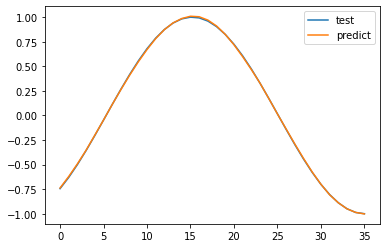

In [124]:
plt.plot(y_test, label='test')
plt.plot(yhat, label='predict')
plt.legend()

## vale lembrar que a curva é bem similar a uma seção da curva do cosseno